<a href="https://colab.research.google.com/github/rubanzasilva/flood_probability/blob/main/s04e05_fastai_exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

In [ ]:
#hide
!pip install catboost
!pip install fastkaggle
#!pip install optuna
#!pip install optuna_distributed
#!pip install autogluon
!pip install openfe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.2 MB/s eta 0:00:00


In [ ]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp
#import optuna
#import optuna_distributed

#from autogluon.tabular import TabularDataset, TabularPredictor

from openfe import OpenFE, transform

In [ ]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"3c109650146efc9c92fc9e8bfe70d487"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
comp = 'playground-series-s4e5'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 28.0M/28.0M [00:00<00:00, 246MB/s]

In [ ]:
!ls playground-series-s4e5

sample_submission.csv  test.csv  train.csv


In [ ]:
#set_seed(42)

In [ ]:
path = Path('playground-series-s4e5/')
path

Path('playground-series-s4e5')

In [ ]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
original_df = pd.read_csv(path/'flood.csv')

In [ ]:
train_final = pd.concat([train_df,original_df], axis=0)
train_final.shape

(1167957, 21)

# EDA

### Descriptive statistics

In [ ]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167957 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1167957 non-null  int64  
 1   TopographyDrainage               1167957 non-null  int64  
 2   RiverManagement                  1167957 non-null  int64  
 3   Deforestation                    1167957 non-null  int64  
 4   Urbanization                     1167957 non-null  int64  
 5   ClimateChange                    1167957 non-null  int64  
 6   DamsQuality                      1167957 non-null  int64  
 7   Siltation                        1167957 non-null  int64  
 8   AgriculturalPractices            1167957 non-null  int64  
 9   Encroachments                    1167957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1167957 non-null  int64  
 11  DrainageSystems                  1167957 non-null  int64 

In [ ]:
train_final.describe()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,...,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06
mean,4.924448e+00,4.929129e+00,4.957917e+00,4.945076e+00,4.944509e+00,4.936415e+00,4.958424e+00,4.930394e+00,4.945338e+00,4.951676e+00,...,4.949426e+00,4.955965e+00,4.933638e+00,4.931206e+00,4.928574e+00,4.929979e+00,4.953182e+00,4.942889e+00,4.941209e+00,5.042740e-01
std,2.064482e+00,2.100671e+00,2.079283e+00,2.059346e+00,2.090501e+00,2.065289e+00,2.090286e+00,2.073436e+00,2.075964e+00,2.090378e+00,...,2.079734e+00,2.095936e+00,2.084931e+00,2.089052e+00,2.072244e+00,2.081498e+00,2.075967e+00,2.087742e+00,2.097278e+00,5.099335e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.900000e+01,2.200000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [ ]:
train_final.isna().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

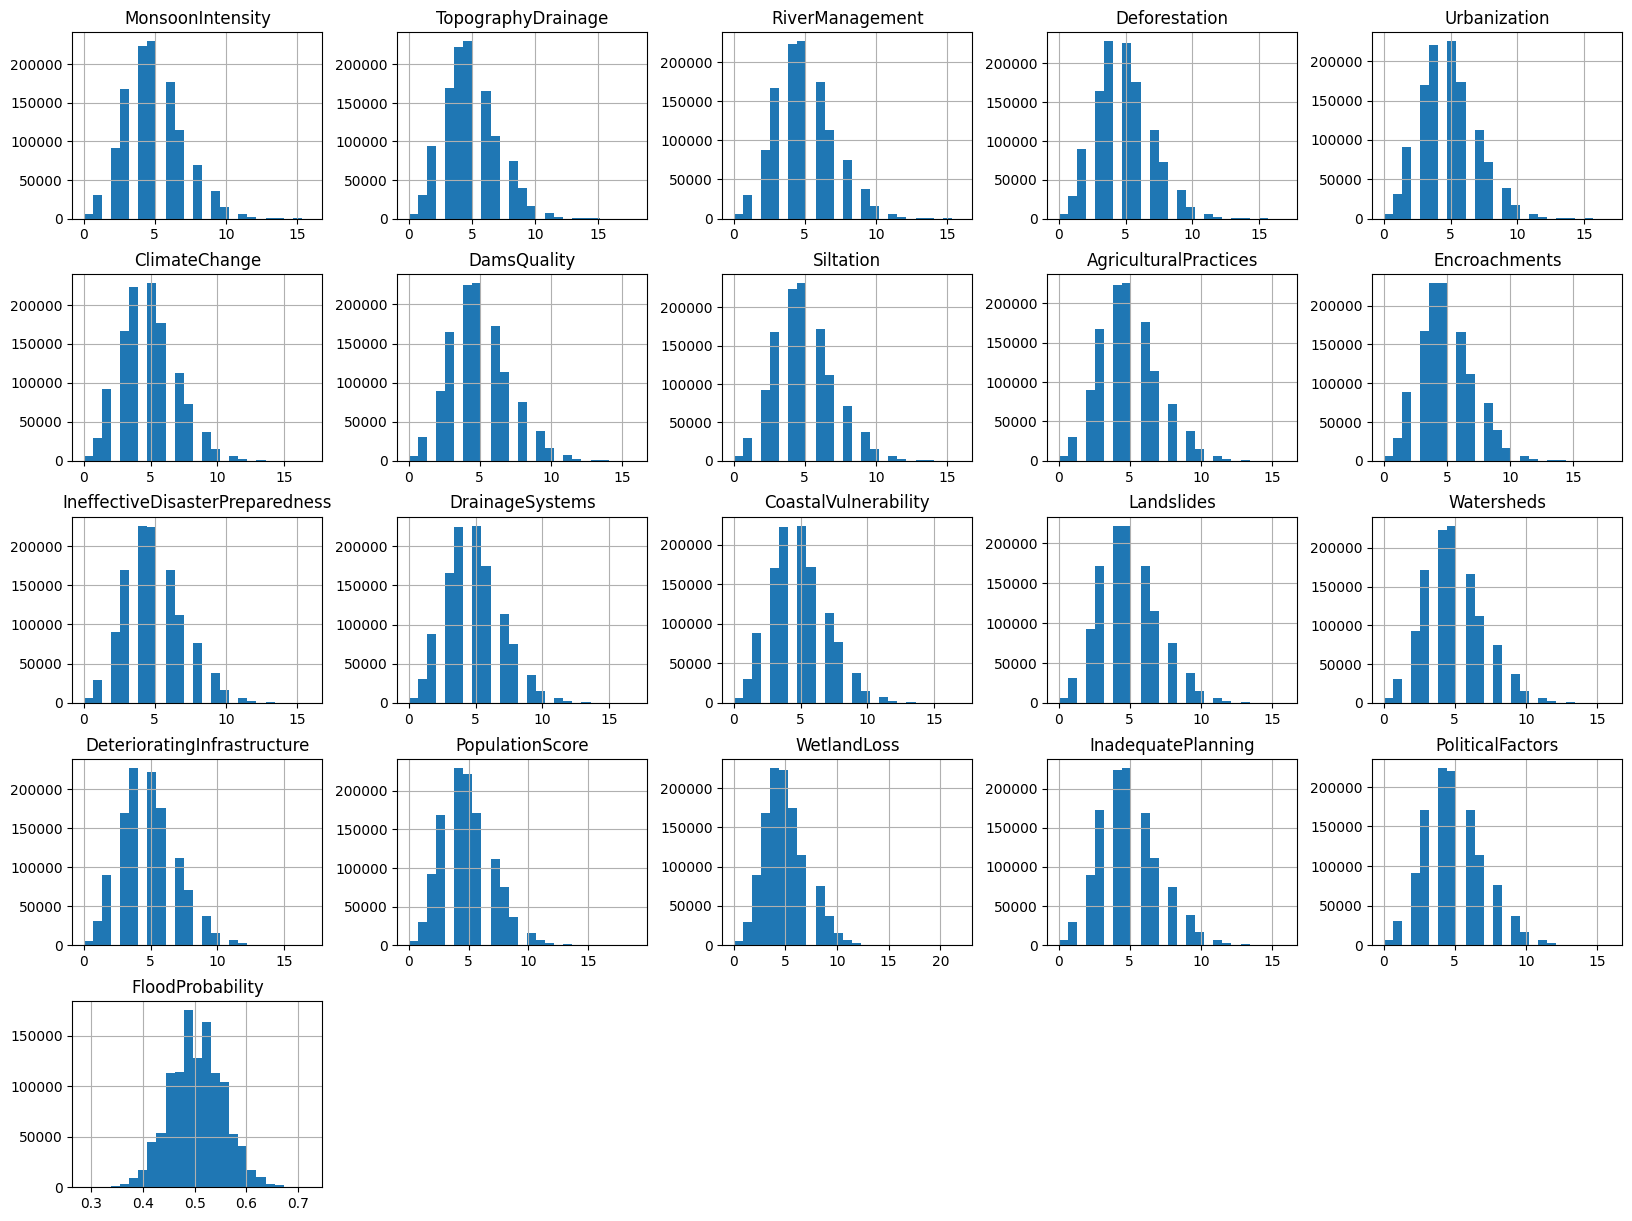

In [ ]:
train_final.hist(bins=25, figsize=(20,15));

### Looking at specific columns

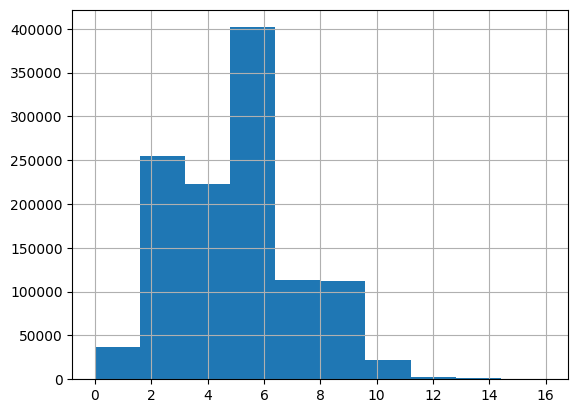

In [ ]:
train_final['RiverManagement'].hist();

In [ ]:
train_final.describe()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,...,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06,1.167957e+06
mean,4.924448e+00,4.929129e+00,4.957917e+00,4.945076e+00,4.944509e+00,4.936415e+00,4.958424e+00,4.930394e+00,4.945338e+00,4.951676e+00,...,4.949426e+00,4.955965e+00,4.933638e+00,4.931206e+00,4.928574e+00,4.929979e+00,4.953182e+00,4.942889e+00,4.941209e+00,5.042740e-01
std,2.064482e+00,2.100671e+00,2.079283e+00,2.059346e+00,2.090501e+00,2.065289e+00,2.090286e+00,2.073436e+00,2.075964e+00,2.090378e+00,...,2.079734e+00,2.095936e+00,2.084931e+00,2.089052e+00,2.072244e+00,2.081498e+00,2.075967e+00,2.087742e+00,2.097278e+00,5.099335e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.900000e+01,2.200000e+01,1.600000e+01,1.600000e+01,7.250000e-01


### Correlation

# Baseline

No original dataset

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

SuggestedLRs(slide=0.010964781977236271, valley=0.0008317637839354575)

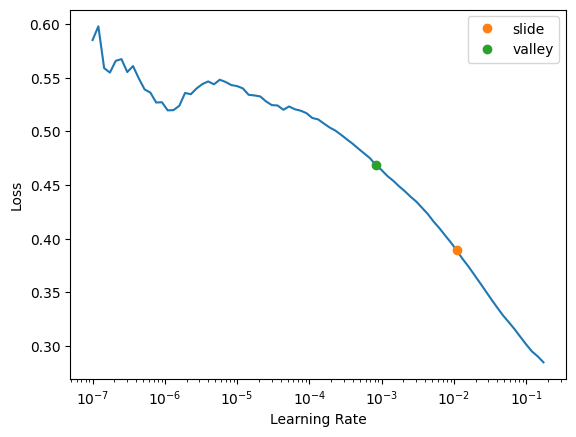

In [ ]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
%%time
learn.fit_one_cycle(10,0.012)

epoch,train_loss,valid_loss,r2_score,time
0,0.000583,0.000572,0.780385,04:00
1,0.000562,0.000462,0.822535,03:44
2,0.000533,0.000488,0.812753,03:54
3,0.000526,0.000413,0.841586,04:24
4,0.000481,0.000511,0.803786,04:23
5,0.000500,0.000409,0.842913,04:23
6,0.000460,0.000422,0.837914,04:19
7,0.000421,0.000386,0.851938,04:16
8,0.000421,0.000373,0.856692,04:14
9,0.000388,0.000370,0.857997,04:19


CPU times: user 41min 3s, sys: 12.5 s, total: 41min 16s
Wall time: 42min


In [ ]:
#learn.fit_one_cycle(5,0.02)
%%time
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()


CPU times: user 2min 46s, sys: 999 ms, total: 2min 47s
Wall time: 2min 48s


In [ ]:
#0.02 no original dataset
r2_score(y_test,nn_preds_x)

0.857997236462503

# OpenFe

In [ ]:
train_y = train_df['FloodProbability']
train_x = train_df.drop('FloodProbability',axis=1)

In [ ]:
train_x = train_df.drop('FloodProbability',axis=1)

In [ ]:
test_x = test_df
train_x.shape,train_y.shape,test_x.shape

((1117957, 20), (1117957,), (745305, 20))

In [ ]:
train_x.shape,train_y.shape,test_x.shape

((1117957, 20), (1117957,), (745305, 20))

In [ ]:
ofe = OpenFE()

In [ ]:
y_names='FloodProbability'

In [ ]:
#set n_jobs to be the actual cpu core count
CPU_COUNT = os.cpu_count()
n_jobs = CPU_COUNT
n_jobs

2

In [ ]:
params = {"n_estimators": 1000, "importance_type": "gain", "num_leaves": 64,"seed": 1, "n_jobs": n_jobs}

In [ ]:
%%time
from openfe import OpenFE, get_candidate_features, transform, tree_to_formula

ofe1 = OpenFE()
candidate_features_list = get_candidate_features(numerical_features=list(test_df.columns))
features1 = ofe1.fit(data=train_df.drop(y_names,axis=1), label=train_df[y_names],
                     candidate_features_list=candidate_features_list, metric='rmse', task='regression', stage2_params=params,
                     min_candidate_features=5000,
                     n_jobs=n_jobs, n_data_blocks=2, feature_boosting=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504471
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3117]	valid_0's rmse: 0.0203707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3334]	valid_0's rmse: 0.0203727
[LightGBM] [Info] Auto-choosing col-wise multi-threading

  0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009745 seconds.
You can set `force_col_wise=true` t

 12%|█▎        | 1/8 [02:06<14:48, 126.94s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

 25%|██▌       | 2/8 [02:19<05:56, 59.42s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012502 seconds.
You can set `force_col_wise=true` t

 38%|███▊      | 3/8 [04:38<07:58, 95.76s/it]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the t

 50%|█████     | 4/8 [05:50<05:46, 86.66s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

 62%|██████▎   | 5/8 [07:40<04:45, 95.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no 

 75%|███████▌  | 6/8 [08:45<02:49, 84.83s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

 88%|████████▊ | 7/8 [10:12<01:25, 85.43s/it]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

100%|██████████| 8/8 [10:41<00:00, 80.13s/it]


133 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


  0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019325 seconds.
You can set `force_col_wise=true` 

 12%|█▎        | 1/8 [04:01<28:10, 241.44s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045413 seconds.
You can set `force_col_wise=true` 

 25%|██▌       | 2/8 [04:23<11:14, 112.35s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 38%|███▊      | 3/8 [07:31<12:13, 146.78s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

 50%|█████     | 4/8 [08:20<07:12, 108.12s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037617 seconds.
You can set `force_col_wise=true` 

 62%|██████▎   | 5/8 [10:41<06:00, 120.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the 

 75%|███████▌  | 6/8 [12:21<03:46, 113.12s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

 88%|████████▊ | 7/8 [13:54<01:46, 106.53s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

100%|██████████| 8/8 [15:31<00:00, 116.39s/it]


The number of remaining candidate features is 451
Start stage II selection.


100%|██████████| 8/8 [01:01<00:00,  7.70s/it]


In [ ]:
train_new, test_new = transform(train_df.drop(y_names,axis=1), test_df, features1[:300], n_jobs=n_jobs)

In [ ]:
n_jobs = 8

In [ ]:
params = {"n_estimators": 1000, "importance_type": "gain", "num_leaves": 64,"seed": 1, "n_jobs": n_jobs}

In [ ]:
from openfe import OpenFE, get_candidate_features, transform, tree_to_formula

ofe1 = OpenFE()
candidate_features_list = get_candidate_features(numerical_features=list(test_x.columns))
features1 = ofe1.fit(data=train_x, label=train_y,
                     candidate_features_list=candidate_features_list, metric='rmse', task='regression', stage2_params=params,
                     min_candidate_features=5000,
                     n_jobs=n_jobs, n_data_blocks=2, feature_boosting=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504471
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3117]	valid_0's rmse: 0.0203707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3334]	valid_0's rmse: 0.0203727
[LightGBM] [Info] Auto-choosing col-wise multi-threading

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068580 seconds.
You can set `force_col_wise=true` t

  3%|▎         | 1/32 [02:11<1:07:52, 131.38s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 0
[LightGBM] [Warning

  6%|▋         | 2/32 [02:24<30:49, 61.64s/it]   

[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078295 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

  9%|▉         | 3/32 [02:45<20:58, 43.39s/it]


[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

 12%|█▎        | 4/32 [02:56<14:08, 30.29s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Total Bins 18

[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057991 seconds.
You can set `force_col_wise=true`

 16%|█▌        | 5/32 [02:57<08:59, 19.97s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022474 seconds.
You can set `force_row_wise=true` 

 19%|█▉        | 6/32 [03:07<07:11, 16.58s/it]


[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046908 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065399 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 29[LightGBM] [Info] Total Bins 28

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1

[LightGBM] [Info] Auto-choosing col-wise mult

 22%|██▏       | 7/32 [03:09<04:49, 11.59s/it]

[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements[LightGBM] [Info] Total Bins 29

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

 25%|██▌       | 8/32 [03:32<06:05, 15.22s/it]

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 447182, number o

 28%|██▊       | 9/32 [04:21<09:55, 25.91s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

 31%|███▏      | 10/32 [05:00<11:01, 30.07s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

 34%|███▍      | 11/32 [05:03<07:36, 21.71s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

 38%|███▊      | 12/32 [06:06<11:23, 34.18s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020993 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062892 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

 41%|████      | 13/32 [06:13<08:13, 25.95s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1

[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM]

 44%|████▍     | 14/32 [06:51<08:51, 29.51s/it]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079955 seconds.
You can set `force_co

 47%|████▋     | 15/32 [07:04<06:56, 24.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

 50%|█████     | 16/32 [07:15<05:28, 20.50s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_b

 53%|█████▎    | 17/32 [08:17<08:17, 33.15s/it]


[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features

 56%|█████▋    | 18/32 [09:07<08:54, 38.19s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Total Bins 0[LightGBM] [Info] Number of data points in the train set:

 59%|█████▉    | 19/32 [09:14<06:15, 28.90s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] N

 62%|██████▎   | 20/32 [09:23<04:32, 22.72s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067919 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

 66%|██████▌   | 21/32 [09:31<03:23, 18.46s/it]


[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Total Bins 119

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further

 69%|██████▉   | 22/32 [09:58<03:30, 21.04s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 

 72%|███████▏  | 23/32 [10:01<02:20, 15.60s/it]


[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with 

 75%|███████▌  | 24/32 [10:28<02:32, 19.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

 78%|███████▊  | 25/32 [10:33<01:43, 14.81s/it]


[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

 81%|████████▏ | 26/32 [11:35<02:53, 28.85s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

 84%|████████▍ | 27/32 [12:02<02:21, 28.21s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045919 seconds.
You can set `force_col

 88%|████████▊ | 28/32 [12:03<01:21, 20.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031462 seconds.
You can set `force_col

 91%|█████████ | 29/32 [12:07<00:45, 15.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM]

 94%|█████████▍| 30/32 [12:12<00:24, 12.28s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014500 seconds.
You can set `force_col_wise=true` t

 97%|█████████▋| 31/32 [12:15<00:09,  9.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009890 seconds.
You can set `force_col_wise=true` t

100%|██████████| 32/32 [12:16<00:00, 23.02s/it]


133 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114934 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Number of data points in the train set: 894365, numbe

  3%|▎         | 1/32 [03:39<1:53:11, 219.07s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134525 seconds.
You can s

  6%|▋         | 2/32 [04:11<54:46, 109.56s/it]  

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167489 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107377 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bi

  9%|▉         | 3/32 [04:14<29:18, 60.64s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098971 seconds.
You can set `force_col_wise=true` 

 12%|█▎        | 4/32 [04:29<19:51, 42.55s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightG

 16%|█▌        | 5/32 [04:47<15:08, 33.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, b

 19%|█▉        | 6/32 [05:03<12:04, 27.85s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No fu

 22%|██▏       | 7/32 [05:20<10:08, 24.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] 

 25%|██▌       | 8/32 [05:26<07:24, 18.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 25%|██▌       | 8/32 [05:26<16:20, 40.86s/it]


In [ ]:
train_new, test_new = transform((train_x), test_x, features1[:300], n_jobs=n_jobs)

In [ ]:
train_ft1, test_ft1 = transform((train_x), test_x, features1[:300], n_jobs=n_jobs)

NameError: name 'features1' is not defined

In [ ]:
%%time
features = ofe.fit(data=train_x, label=train_y, n_jobs=n_jobs)  # generate new features

In [ ]:
#features = ofe.fit(data=train_x, label=train_y, n_jobs=n_jobs)  # generate new features
%%time
train_x, test_x = transform(train_x, test_x, features, n_jobs=n_jobs) # transform the train and test data according to generated features.

In [ ]:
original_df.shape,train_df.shape

((50000, 21), (1117957, 21))

In [ ]:
train_df = pd.concat([train_df,original_df], axis=0)
train_df.shape

(1167957, 21)

In [ ]:
train_df.shape,test_df.shape

((1167957, 21), (745305, 20))

In [ ]:
#train_df.hist(figsize=(20,15));

In [ ]:
%%time

predictor = TabularPredictor(label='FloodProbability').fit(train_data=train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20240514_113911"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240514_113911"
=================== System

[1000]	valid_set's rmse: 0.0199416
[2000]	valid_set's rmse: 0.0198346
[3000]	valid_set's rmse: 0.0197893
[4000]	valid_set's rmse: 0.0197668
[5000]	valid_set's rmse: 0.0197485
[6000]	valid_set's rmse: 0.0197356
[7000]	valid_set's rmse: 0.0197272
[8000]	valid_set's rmse: 0.0197224
[9000]	valid_set's rmse: 0.0197191
[10000]	valid_set's rmse: 0.019711


	-0.0197	 = Validation score   (-root_mean_squared_error)
	855.11s	 = Training   runtime
	14.44s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.0198579
[2000]	valid_set's rmse: 0.0197987
[3000]	valid_set's rmse: 0.0197629
[4000]	valid_set's rmse: 0.0197453
[5000]	valid_set's rmse: 0.0197325
[6000]	valid_set's rmse: 0.0197309
[7000]	valid_set's rmse: 0.019733
[8000]	valid_set's rmse: 0.0197366


	-0.0197	 = Validation score   (-root_mean_squared_error)
	635.73s	 = Training   runtime
	5.32s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.0342	 = Validation score   (-root_mean_squared_error)
	3142.91s	 = Training   runtime
	1.02s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0195	 = Validation score   (-root_mean_squared_error)
	2471.48s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.0341	 = Validation score   (-root_mean_squared_error)
	1431.4s	 = Training   runtime
	1.54s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0188	 = Validation score   (-root_mean_squared_error)
	942.53s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0201	 = Validation score   (-root_mean_squared_error)
	943.74s	 = Training   runtime
	11.29s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.0193	 = Validation score   (-root_mean_squared_error)
	525.09s	 = Training   runtime
	0.05s	 

[1000]	valid_set's rmse: 0.019948
[2000]	valid_set's rmse: 0.0199006
[3000]	valid_set's rmse: 0.0198917
[4000]	valid_set's rmse: 0.0198945


	-0.0199	 = Validation score   (-root_mean_squared_error)
	446.4s	 = Training   runtime
	5.16s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'NeuralNetFastAI': 0.875, 'NeuralNetTorch': 0.125}
	-0.0188	 = Validation score   (-root_mean_squared_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 11630.16s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240514_113911")


CPU times: user 3h 58min 56s, sys: 54 s, total: 3h 59min 50s
Wall time: 3h 13min 50s


In [ ]:
predictions = predictor.predict(test_df)

In [ ]:
predictions.shape

In [ ]:
predictor.evaluate(train_df)

{'root_mean_squared_error': -0.018936624517170795,
 'mean_squared_error': -0.0003585957481043141,
 'mean_absolute_error': -0.014903989475112229,
 'r2': 0.8620955063143817,
 'pearsonr': 0.928543929859238,
 'median_absolute_error': -0.011987644433975209}

In [ ]:
#predictor.leaderboard(train_df)

KeyboardInterrupt: 

In [ ]:
test_df['Rings'] = predictions
test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "auto gluom  "

Using Full Dataset

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

SuggestedLRs(slide=0.013182567432522774, valley=0.0010000000474974513)

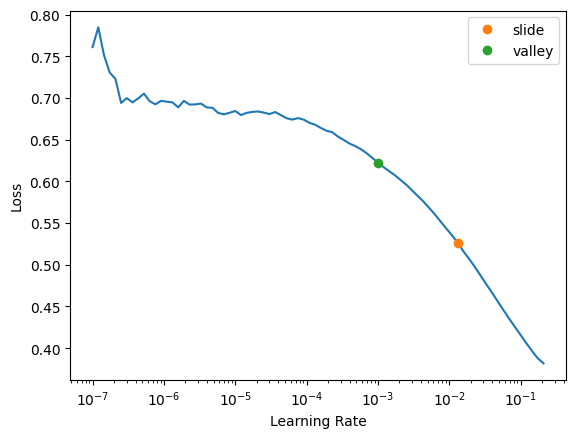

In [ ]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
%%time
learn.fit_one_cycle(20,0.012)

epoch,train_loss,valid_loss,r2_score,time
0,0.000557,0.000544,0.791744,03:09
1,0.000545,0.000490,0.812319,03:00
2,0.000519,0.000446,0.829111,03:06
3,0.000502,0.000468,0.820737,03:07
4,0.000535,0.000684,0.738090,03:20
5,0.000526,0.000497,0.809937,03:31
6,0.000523,0.000432,0.834656,03:31
7,0.000503,0.000439,0.831834,03:34
8,0.000512,0.000408,0.843686,03:33
9,0.000499,0.000447,0.828901,03:33


CPU times: user 1h 10min 26s, sys: 19.4 s, total: 1h 10min 46s
Wall time: 1h 11min 48s


In [ ]:
#learn.fit_one_cycle(5,0.02)
%%time
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()


In [ ]:
#0.02 no original dataset
r2_score(y_test,nn_preds_x)

0.8548811827376223

In [ ]:
#0.012 original dataset
r2_score(y_test,nn_preds_x)

In [ ]:
dl = learn.dls.test_dl(test_df)
def ensemble():
  learn = tabular_learner(dls, metrics=mae)
  with learn.no_bar(), learn.no_logging():
    learn.fit(7, 0.005)
  return learn.get_preds(dl=dl)[0]

learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
ens_preds_x = ens_preds.squeeze(1)
ens_preds_x.shape

torch.Size([745305])

In [ ]:
#ens_preds_y = ensemble()

In [ ]:
dl = learn.dls.test_dl(test_df)
def ensemble():
  learn = tabular_learner(dls, metrics=mae)
  with learn.no_bar(), learn.no_logging():
    learn.fit(7, 0.005)
  return learn.get_preds()[0]

learns = [ensemble() for _ in range(5)]

In [ ]:
#nn_preds_x.shape,ens_preds.shape,z.shape

In [ ]:
target_preds = ens_preds

test_df['Rings'] = target_preds
test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,1117957,0.572660
1,1117958,0.458013
2,1117959,0.454228
3,1117960,0.467618
4,1117961,0.465604


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "ens preds  "

100% 13.2M/13.2M [00:00<00:00, 19.8MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
#0.05 original dataset
r2_score(y_test,nn_preds_x)

0.8610875723288202

In [ ]:
#0.05 original dataset
r2_score(y_test,nn_preds_x)

0.8596201479670931

In [ ]:
target_preds = nn_preds[0]

test_df['Rings'] = target_preds
test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,1117957,0.572530
1,1117958,0.457642
2,1117959,0.455602
3,1117960,0.470247
4,1117961,0.469744


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "nn preds  "

100% 13.2M/13.2M [00:00<00:00, 15.9MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!rm submission.csv

In [ ]:
#0.05 original dataset
r2_score(y_test,nn_preds_x)

0.8610875723288202

# Grid SearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [1500, 2000],
    'max_depth': [6, 10],
    'min_child_weight': [5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'eta': [0.01, 0.05]
}

In [ ]:
xgb_model = xgb.XGBRegressor()

In [ ]:
xg_grid_search = GridSearchCV(param_grid=param_grid,)

In [ ]:
#0.05 original dataset
r2_score(y_test,nn_preds_x)

0.8609544681285392

In [ ]:
#0.008 with original dataset
r2_score(y_test,nn_preds_x)

0.8531591084930723

In [ ]:
#0.008, no original dataset
r2_score(y_test,nn_preds_x)

0.8596047522511752

In [ ]:
#0.05 no original dataset
r2_score(y_test,nn_preds_x)

0.8495222993640157

In [ ]:
#0.05 no original dataset
r2_score(y_test,nn_preds_x)

0.8609544681285392

In [ ]:
learn.export('models/fp_colab_model.pkl')

In [ ]:
!ls models

fp_colab_model.pkl


In [ ]:
learn.load('fp_colab_model.pkl')

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submision.csv', 'nn preds', comp)

# AutoGluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor = TabularPredictor(label='FloodProbability').fit(train_data=train_df)
predictions = predictor.predict(test_df)

ImportError: cannot import name '_is_pandas_df' from 'sklearn.utils' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/__init__.py)

# Random Forest Baseline

In [ ]:
%%time
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=10)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

CPU times: user 7min 16s, sys: 1.05 s, total: 7min 17s
Wall time: 7min 27s


0.6037340079879046

# Optimize Params with Optuna

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, lgb_predictions, squared=False)
    return rmse

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=100)
print(study_xgboost.best_params)

# CatBoost

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

In [ ]:
print(study_catboost.best_params)

{'learning_rate': 0.2916627098129582, 'depth': 8, 'random_strength': 1}


In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 9min 58s, sys: 6.55 s, total: 10min 5s
Wall time: 6min 32s


0.8481915205331098

In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 10min 46s, sys: 6.3 s, total: 10min 52s
Wall time: 6min 45s


0.851050043448554

In [ ]:
r2_score(y_test,cat_preds_x)

NameError: name 'cat_preds_x' is not defined

In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=1441, depth=10, learning_rate= 0.08, random_strength=27)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 16min 53s, sys: 4.82 s, total: 16min 58s
Wall time: 10min 6s


0.8484108713271834

In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=1441, depth=10, learning_rate= 0.08, random_strength=27)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 16min 52s, sys: 5.05 s, total: 16min 57s
Wall time: 10min 10s


0.8484108713271834

In [ ]:
%%time

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score

# Create a study
study_catboost = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_catboost = optuna_distributed.from_study(study_catboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_catboost.optimize(objective_catboost, n_trials=100, n_jobs=num_parallel_jobs)

print(study_catboost.best_params)

In [ ]:
%%time
def objective(trial):
  model = CatBoostRegressor(
      iterations=trial.suggest_int("iterations", 1000, 3000),
      learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
      colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
      min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
      depth=trial.suggest_int("depth", 4, 15),
      l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
      verbose=False,
      random_state=27
      )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return np.sqrt(r2_score(y_test, y_pred))


 #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)



CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.9 µs


In [ ]:
 %%time
 optuna.logging.set_verbosity(optuna.logging.WARNING)

 sampler = optuna.samplers.TPESampler(seed=27)
 study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
 study.optimize(objective, n_trials=30)



In [ ]:
 print("Number of finished trials: ", len(study.trials))
 print("Best trial:")
 trial = study.best_trial
 print("  Value: ", trial.value)
 print("  Params: ")

 for key, value in trial.params.items():
     print(f"    {key}: {value}")
 print()

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat_boost"

100% 13.2M/13.2M [00:01<00:00, 9.87MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!rm submission.csv

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip


# XGBoost

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=100)
print(study_xgboost.best_params)

[I 2024-05-08 21:34:25,097] A new study created in memory with name: no-name-8ae3b642-30df-4721-b8b7-f3dbb30d5a76
[I 2024-05-08 21:34:38,452] Trial 0 finished with value: 0.0323333740234375 and parameters: {'n_estimators': 180, 'max_depth': 2, 'learning_rate': 0.0767006457556867, 'subsample': 0.7884890645620555}. Best is trial 0 with value: 0.0323333740234375.
[I 2024-05-08 21:35:13,275] Trial 1 finished with value: 0.021586356684565544 and parameters: {'n_estimators': 164, 'max_depth': 10, 'learning_rate': 0.14377450978725867, 'subsample': 0.8482468806222986}. Best is trial 1 with value: 0.021586356684565544.
[I 2024-05-08 21:35:36,705] Trial 2 finished with value: 0.02356773428618908 and parameters: {'n_estimators': 128, 'max_depth': 9, 'learning_rate': 0.28199233688931646, 'subsample': 0.28153556236937083}. Best is trial 1 with value: 0.021586356684565544.
[I 2024-05-08 21:35:50,018] Trial 3 finished with value: 0.045142143964767456 and parameters: {'n_estimators': 103, 'max_depth':

{'n_estimators': 197, 'max_depth': 4, 'learning_rate': 0.1818695751227044, 'subsample': 0.39774994666482544}


In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 197, max_depth=4, learning_rate=0.1818695751227044, subsample= 0.39774994666482544)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.8328108326764126

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, xgb_predictions)
    return r2score


study_xgboost = optuna.create_study(direction='minimize')


# Convert the study to a distributed study
study_xgboost = optuna_distributed.from_study(study_xgboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_xgboost.optimize(objective_xgboost, n_trials=100, n_jobs=num_parallel_jobs)


print(study_xgboost.best_params)

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 767, max_depth=13, learning_rate=0.22472048294428892, subsample= 0.8936985751131682, min_child_weight=10, gamma=8.58031910185836e-07, colsample_bytree=0.04050040446078567, reg_alpha=0.16025160863896398, reg_lambda=6.875124639971543e-08, random_state=27)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.8459411327560431

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = xgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat_boost"

100% 13.2M/13.2M [00:01<00:00, 8.87MB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (12 hours from now).


# Light GBM

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, lgb_predictions, squared=False)
    return rmse

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

[I 2024-05-08 22:09:51,585] A new study created in memory with name: no-name-af8b0f7a-bd8c-403c-bddf-9dd53f48a69c


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 22:10:14,977] Trial 0 finished with value: 0.02122505765570546 and parameters: {'num_leaves': 29, 'learning_rate': 0.22104258573435334, 'n_estimators': 132}. Best is trial 0 with value: 0.02122505765570546.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[W 2024-05-08 22:10:22,624] Trial 1 failed with parameters: {'num_leaves': 48, 'learning_rate': 0.06196305605637638, 'n_estimators': 172} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-27-c89ead468ece>", line 8, in objective_lgbm
    model.fit(X_train, y_train)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1049, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 276, in train
    booster.update(fobj=fobj)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 3658, in update
    _safe_call(_LIB.LGBM_BoosterUpdateOneIter(
KeyboardInterrupt
[W 2024-05-08 22:10:22,632] Trial 1 failed with v

KeyboardInterrupt: 

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504451


0.8353827730240946

In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')


# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)


print(study_lgbm.best_params)

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
mse = mean_absolute_error(y_test,cat_preds_x)
rmse = np.sqrt(mse)
rmse

0.12580042

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat boost"

100% 13.2M/13.2M [00:01<00:00, 9.79MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

# Model Ensemble

In [ ]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds.shape

torch.Size([223591])

In [ ]:
#for r2_Score testing
general_preds = (xgb_preds_x + cat_preds_x + nn_preds_m)/3
general_preds.shape

torch.Size([233591])

In [ ]:
#for r2_Score testing
general_preds = (cat_preds_x + nn_preds_m)/2
general_preds.shape

torch.Size([233591])

In [ ]:
r2_score(y_test,general_preds)

0.858287865688015

In [ ]:
r2_score(y_test,general_preds)

0.8582584096219742

In [ ]:
general_preds

tensor([0.3679, 0.5352, 0.5139,  ..., 0.5351, 0.4667, 0.4714])

In [ ]:
#use for submission
general_preds = ( cat_preds + nn_preds_y)/2
general_preds

tensor([0.5736, 0.4575, 0.4550,  ..., 0.6213, 0.5514, 0.5128])

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

catboost_info  kaggle.json  playground-series-s4e5	sample_data
gdrive	       models	    playground-series-s4e5.zip


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "general preds ( cat_preds + nn_preds_y )"

100% 13.2M/13.2M [00:00<00:00, 14.1MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
# Check if the KAGGLE_USERNAME environment variable is set
#iskaggle = 'KAGGLE_USERNAME' in os.environ

if not iskaggle:
    push_notebook('rubanzasilva', 's04e05_fastai_exp1',
                 title='Flood Probability: s04e05_fastai_exp1',
                 file='s04e05_fastai_exp1.ipynb',
                 competition=comp, private=False, gpu=True)


NameError: name 'push_notebook' is not defined

In [ ]:
if not iskaggle:
    push_notebook('jhoward', 'first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)

NameError: name 'iskaggle' is not defined

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.046018206875864616, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

KeyboardInterrupt: 

In [ ]:
r2_score(y_test,xgb_preds_x)

0.7817602531907657

In [ ]:
mse = mean_absolute_error(y_test, xgb_preds_x)
rmse = np.sqrt(mse)
rmse

0.13967574

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504491


0.8235475438046409

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!rm submission.csv

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip


In [ ]:
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability
0,1117957,0.575180
1,1117958,0.463337
2,1117959,0.450641
3,1117960,0.460754
4,1117961,0.461083
...,...,...
745300,1863257,0.484195
745301,1863258,0.457408
745302,1863259,0.634439
745303,1863260,0.566786


In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "lgb preds"

100% 13.2M/13.2M [00:00<00:00, 17.0MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = rf_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability,Rings
0,1117957,0.5,0.568910
1,1117958,0.5,0.454981
2,1117959,0.5,0.450971
3,1117960,0.5,0.471085
4,1117961,0.5,0.470031
...,...,...,...
745300,1863257,0.5,0.475079
745301,1863258,0.5,0.446771
745302,1863259,0.5,0.616611
745303,1863260,0.5,0.546384


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "rf_preds"

In [ ]:
!ls

In [ ]:
general_preds = (lgb_preds + xgb_preds + cat_preds)

In [ ]:
general_preds

tensor([1.7166, 1.3715, 1.3782,  ..., 1.8436, 1.6442, 1.5364])